# Part 2 - Markov Chain Monte Carlo Neutrino Event Reconstruction

By "Le Nguyen"

<img src="https://news.wisc.edu/content/uploads/2017/11/MUon.gif" width="100%">

Image from: https://news.wisc.edu/content/uploads/2017/11/MUon.gif

---
# Abstract


I am an undergraduate research assistance working with the IceCube Neutrino Detection Observatory group at MSU. My work is to take the resulting data from the aftermath of a simulated neutrino interaction with the IceCube detector and work backwards to figure out what characteristics the neutrino had before the interaction. To do this, I use key features from the event (the after math of the neutrino interaction) and used them to pull up relevant likelihood table of the type of neutrino that may have produce this event. For instance, if I have 13 GeV of deposited energy in the aftermath of my event and I wanted to know that mass of my neutrino I could pull up a likelihood distribution of the masses of neutrinos that deposited 13 GeV of energy to find the most likely mass.  

I do this for 10 parameters of the event to get a precise description of the neutrino that caused it. This means I am trying to maximize a 10-dimensional likelihood space (technically it is minimizing because I am using an inverse log likelihood) which is a computational nightmare. It’s a high dimensional irregular likelihood space that most optimization algorithms cannot handle, so the choice algorithm Markov Chain Monte Carlo (MCMC). MCMC uses a set of random but selective walkers to step through a likelihood space and converge at the minimum of maximum. In my research I do this by wrapping in-house IceCube software in python. The IceCube software spits out likelihood values and python takes them and decides where to take the next step in the likelihood space.  

MCMC is a pleasantly parallel problem, multiple independent random walkers can be exploring the likelihood space at the same time and their results can be compiled at the end. I did this and looked at the timing gains and accuracy of spliting up my one big walker into more smaller walkers. As I expected, I main huge gains in run time, but could not determine the accuracy of my results well. I suspect the main problem is how my walkers are seeded on the likelihood space, which is a new problem to me because this is the first time I have ran it in parallel!

---
# Methodology


Performing the same timing study I did in this project is rather straight forward. First I ran my run_MCMC.sb script as detialed in the README which 2,000,000 steps (the steps parameter is in thousands, so 2,000 steps given in the submission script) and a job array size of 1, or 1 walker. This gave me a baseline for the serial verison of the code. Then I started to explore with adding more walkers, increasing the job array size, while maintaining the same number of steps. With the number of steps per walker being 2,000,000/# of walkers (rounding up if the number is a fraction) this distributed the number of steps over many walkers, thus parallelizing the job. 

I started with 1 walker, then 10 and increased the number of walker by 10 until I got to 100 walkers, each taking 20,000 steps. For convience, the data files for each array where given their own directory. So the ten walker job outputed to one directed, the 20 walker to another and so on. Once ever job array finished I concatinated all of the files in each directory into one data file for analysis using the 'concat_files.py' script. Also, to get the time for each set of walkers, I looked into the slurm output for each array to find the maximum time one of the walkers took to ran. The script prints the runtime of each walker as the last line in the slrum output, so it is easy to grep the last line of each output file and find the max runtime. I chose the max runtime of a walker because that represents the true time it takes the job to finish, since it's not done until all walkers are finished. 

Now with the time it took to run all of the varying amounts of walkers done, I wanted to check the accuracy. To do this I loaded every one of my concatenated data files into 'Analyze_Data.ipynb'. This notebook will create histograms of all of the parameters and also save the x (bin value) and y (counts) of all the histograms. I then found the x value that corrosponded to the largest y value (the bin value with the highest counts). This was the value that the walkers converged to the most which is the answer the chain is giving. 

The truth value to the parameter the chain is trying to find is appended to the end of the chain when it is done running, so truth = steps[-1]. With the truth value, we can determine the accuracy of the markov chain. The error metric I used was the sum of the relative errors of all the parameters. The parameters span multiple orders of magnitude so I used the relative error to normalize then against each other. Then the sum of all the relative errors is the overall error of the markov chain. 

To finish, I plotted the time it to run each job against the number of walkers as well as the error for each number of walkers. The results can be seen in the next section. 

---
# Timing Results


In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
walkers = [1,10,20,30,40,50,60,70,80,90,100]

Walkers:Time (Hours)
1: 16.7175
10: 1.3340852319444445
20: 1.8054326383333335
30: 0.8207511172222222
40: 1.0979614977777779
50: 0.40359771694444446
60: 0.3827625969444445
70: 0.26945514833333334
80: 0.14769786166666668
90: 0.11908190888888888
100: 0.22583333333333333

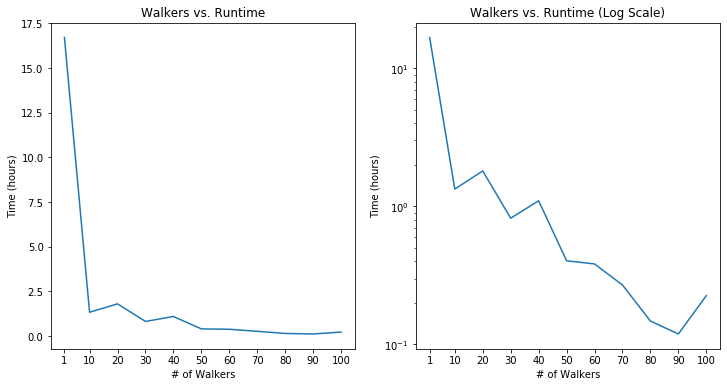

In [32]:
times = [16.7175,1.3340852319444445, 1.8054326383333335, 0.8207511172222222,1.0979614977777779,0.40359771694444446,
        0.3827625969444445,0.26945514833333334,0.14769786166666668,0.11908190888888888,0.22583333333333333]
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(walkers,times)
plt.title("Walkers vs. Runtime")
plt.ylabel("Time (hours)")
plt.xlabel("# of Walkers")
plt.xticks(walkers)

plt.subplot(1,2,2)
plt.plot(walkers,times)
plt.yscale("log")
plt.title("Walkers vs. Runtime (Log Scale)")
plt.ylabel("Time (hours)")
plt.xlabel("# of Walkers")
plt.xticks(walkers);

Timing Study Results

-All work was done on dev-intel16-k80-

The results of the timing study are as expected. In general I would expect this to behave like 1/x where x is the number of walkers. As the number of walkers increases, the run time decreases in general. There are some slight variations in the runtime but I attribute this to some of the randomness in the code and in resource allocation in the HPCC. If I where to run this multiple times I would expect these variations to smooth out. As the number of walkers increaes there is diminising returns in terms of speed up which can easily be seen in the math. The difference between 1 walker and 10 walkers is huge, 1/10th the run time, but the difference between 90 and 100 walkers is not so noticable since it's the difference between .01111... and .01 at that point. I would say after 50-60 walkers, the gains start to plateau and need to be weighed against the time it will take to queue and run that many jobs. 



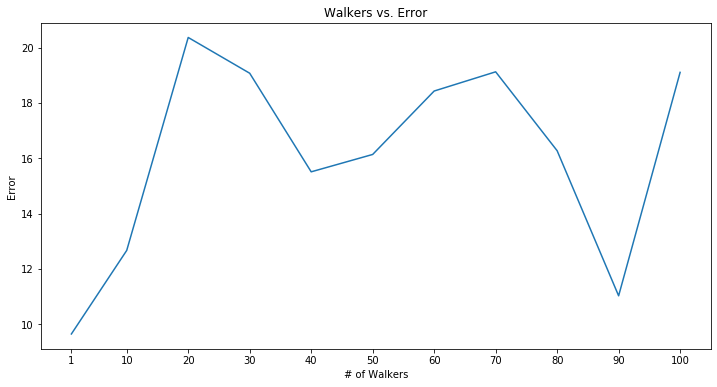

In [34]:
error = [9.64658480441944,12.667669699288853,20.36722274901699,19.07371020635893,15.50930291964723,16.1375302614887,
        18.430728536765773,19.125045311864987,16.27209569038553,11.026851938174882,19.105421186057352]

plt.figure(figsize = (12,6))
plt.plot(walkers,error)
plt.title("Walkers vs. Error")
plt.ylabel("Error")
plt.xlabel("# of Walkers")
plt.xticks(walkers);

Accuracy Study Results

-All work was done on dev-intel16-k80-

The results for accuracy are chaotic and definately need to be looked into further. My expectation was a parabolic shape where the results would get more accurate as the number of walkers increased until the walkers started to become too short to converage and would become inaccurate. In theory, the more walkers on the likelihood space, the better because more values of the likelihood space are being sampled so the odds of finding a global minimum are better. To my surprise (since this is the first time I have seen the results of parallelization) this was not the case. 

There isn't any clear behavior shown in the number of walkers vs. error. I could run this study multiple times to see if this holds true on average, but I have a hunch why this is happening. Each array of walkers is randomly seeded within the bounds of the likelihood space for each parameter. Say the likelihood space of x extends from -10 to 10 and we are using 100 walkers. 100 points are randomly sampled on the interval and those points are used as the starting point for each walker. This is done to explore the likelihood space thoroughly, but it's possible that a collective 2,000,000 steps was not enough to get good convergence for even 10 walkers. The arrays of walkers that did better than others most likely got lucky with having more seed points nearer to the minimums than others. They got lucky. 



---
# Concluding Discussion and Future Work



Overall, the parallelization of my Markov Chain Monte Carlo was a success timing wise, but in terms of accuracy further study is needed. The run time of the chain was reduced by adding more walkers as expected. Parallelization did not improve accuracy though and so far the limit data shows there is a decrease in accuracy. 

The next step is too run the study again with more steps overall, perhaps 20,000,000 plus to see if the seperate chains needed more steps to converge. Another avenue is to look at a more intelligent way to seed the walkers in the likelihood space and adjust the number of burn in steps. There could be a way to make a general guess of where the global minimum is in the likelihood space (this is simulated data so I know the truth value, but seeding at it would defeat the purpose) and seed around it instead of entirely random seeds. Adjusting the numer of burn in steps (steps throw away at the beginning of the chains) would probably help as well, since most of the beginning steps the walkers take are junk as they are exploring the space. 

---
# References


All IceCube software
https://docs.icecube.aq/combo/trunk/index.html

CVMFS environment
https://docs.icecube.aq/combo/trunk/info/cvmfs.html